In [1]:
# dataframe / analysis tools
import pandas as pd
import numpy as np
import scipy as sp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


def zscore(x):
    return (x - np.mean(x))/np.std(x)

In [2]:
df_hw = pd.read_csv('C:/Users/Cglan/Desktop/github/civicu-machine-learning/lessons/shared-resources/heights_weights_genders.csv')
df_hw.head().append(df_hw.tail())

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
9995,Female,66.172652,136.777454
9996,Female,67.067155,170.867906
9997,Female,63.867992,128.475319
9998,Female,69.034243,163.852461
9999,Female,61.944246,113.649103


### Questions

1. Is our data normally distributed?
2. What does our covariance matrix look like?
3. Are there any transformations to do on the data?
4. Should we split the data up in any way?


### Explore and Preprocess Data

In [45]:
np.cov(df_hw.drop('Gender', 1).apply(lambda x: zscore(x),1).T)

array([[  2.36891502e-32,   1.79434496e-32],
       [  1.79434496e-32,   2.37322953e-32]])

In [3]:
df_m = df_hw.query("Gender == 'Male'").iloc[:,1:3]
df_f = df_hw.query("Gender == 'Female'").iloc[:,1:3]

#### Plot Heights and Weights Density Distribution
Make a Kernal Density Estimate plot. [More about KDE.]('https://en.wikipedia.org/wiki/Kernel_density_estimation')

Note, your data should be Normally distributed! If your data does not look normal, transform it with a function like `np.log()`.

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


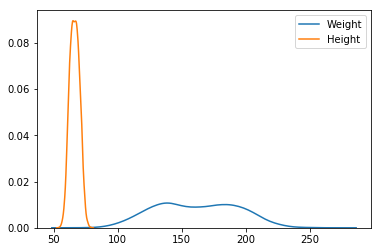

In [52]:
## Your turn: 
sns.kdeplot(df_hw.Weight)
sns.kdeplot(df_hw.Height)

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


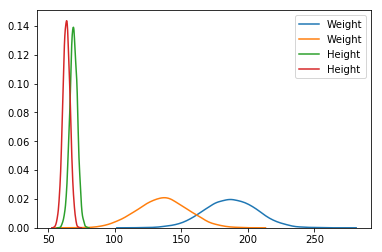

In [4]:
## Your turn: 
sns.kdeplot(df_m.Weight)
sns.kdeplot(df_f.Weight)
sns.kdeplot(df_m.Height)
sns.kdeplot(df_f.Height)

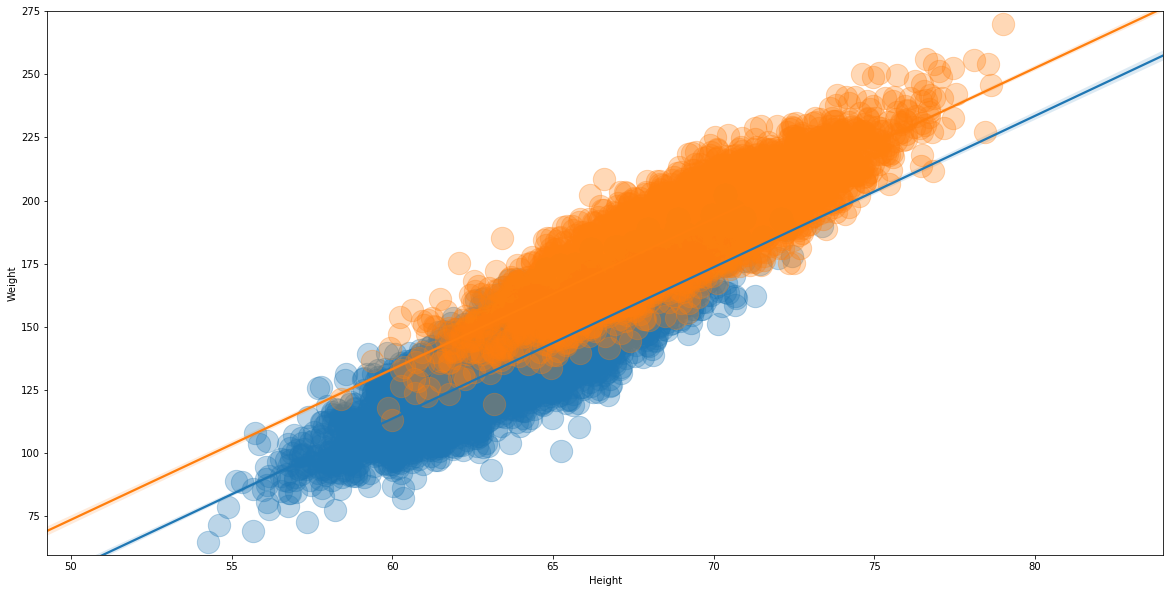

In [5]:
plt.figure(figsize=(20,10))
plt.ylim(df_hw.Weight.min()-5, df_hw.Weight.max()+5)
plt.xlim(df_hw.Height.min()-5, df_hw.Height.max()+5)
sns.regplot(df_f.Height, df_f.Weight, scatter_kws={'alpha':0.3,'s':500})
sns.regplot(df_m.Height, df_m.Weight,scatter_kws={'alpha':0.3,'s':500})

## Run Gaussian Anomaly Detection

In [55]:
df_m_raw = df_hw.query("Gender == 'Male'").iloc[:,1:3]
df_f_raw = df_hw.query("Gender == 'Female'").iloc[:,1:3]

df_m = df_m_raw.apply(zscore,0)
df_f = df_f_raw.apply(zscore,0)

df_m = df_m.apply(lambda x:sp.stats.norm.pdf((x)),1)
df_f = df_f.apply(lambda x: sp.stats.norm.pdf((x)),1)

df_m['prob'] = df_m.apply(np.prod,1)
df_f['prob'] = df_f.apply(np.prod,1)


,Height,Weight,prob
2014,78.998742,269.989699,5.577532e-08
4794,58.406905,121.338323,6.604217e-07
1942,59.981865,112.902939,9.675330e-07
4637,59.868078,117.803842,2.092705e-06
3285,78.528210,253.889004,2.129362e-06
3155,68.930729,186.781004,1.590545e-01
2139,68.963534,187.519514,1.590660e-01
2834,69.022974,187.568690,1.590937e-01
3868,69.048058,187.468162,1.591096e-01
891,68.997110,186.635313,1.591165e-01


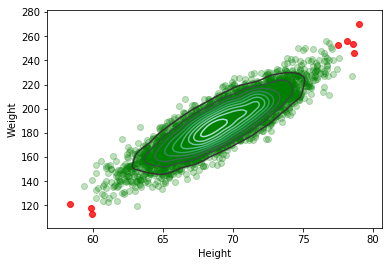

In [56]:
mask_m = df_m.prob < 1/100000
sns.kdeplot(df_m_raw.Height, df_m_raw.Weight)
sns.regplot(x="Height", y="Weight", data=df_m_raw[~mask_m],fit_reg=False,color='g',scatter_kws={'alpha':0.25})
sns.regplot(x="Height", y="Weight", data=df_m_raw[mask_m],fit_reg=False,color='red')

describe_m = pd.concat([df_m_raw, df_m['prob']], 1).sort_values('prob')
describe_m.head().append(describe_m.tail())

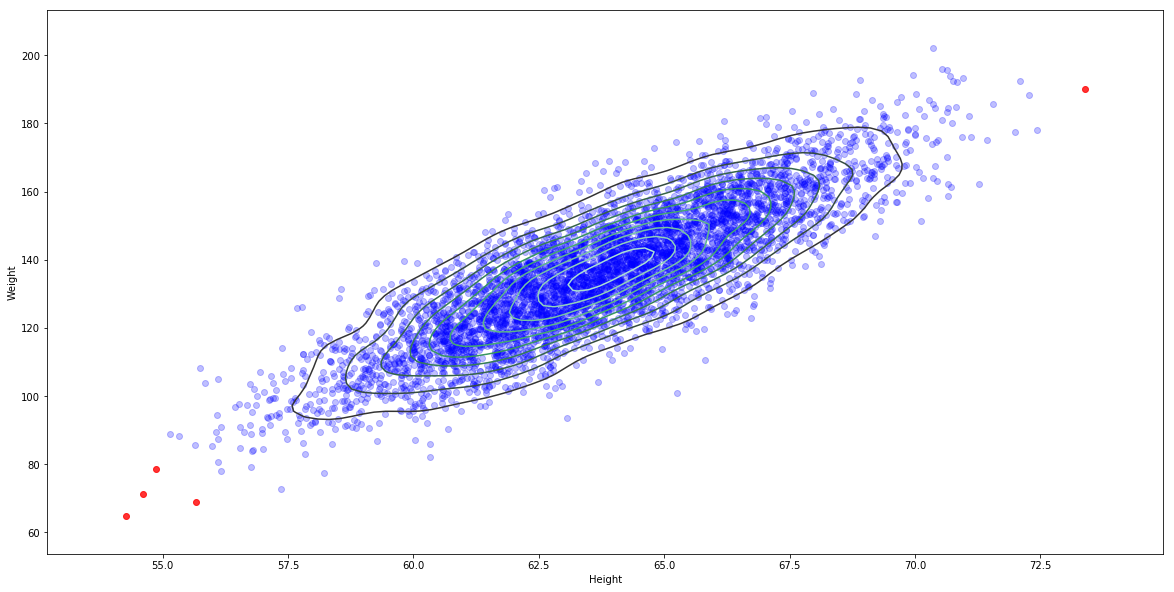

In [77]:
mask_f = df_f.prob < 1/100000

plt.figure(figsize=(20,10))
sns.kdeplot(df_f_raw.Height, df_f_raw.Weight)
sns.regplot(x="Height", y="Weight", data=df_f_raw[~mask_f],fit_reg=False,color='b',scatter_kws={'alpha':0.25})
sns.regplot(x="Height", y="Weight", data=df_f_raw[mask_f],fit_reg=False,color='red')

## "Elliptic" Gaussian Anomaly Detection

What are some things wrong with our attempt?

In [59]:
from scipy.stats import multivariate_normal
from scipy.stats import uniform

def estimateGaussian(x):
    mu = np.mean(x, axis=0)
    sigma = np.cov(x.T)
    return mu, sigma

def multivariateGaussian(x,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(x)

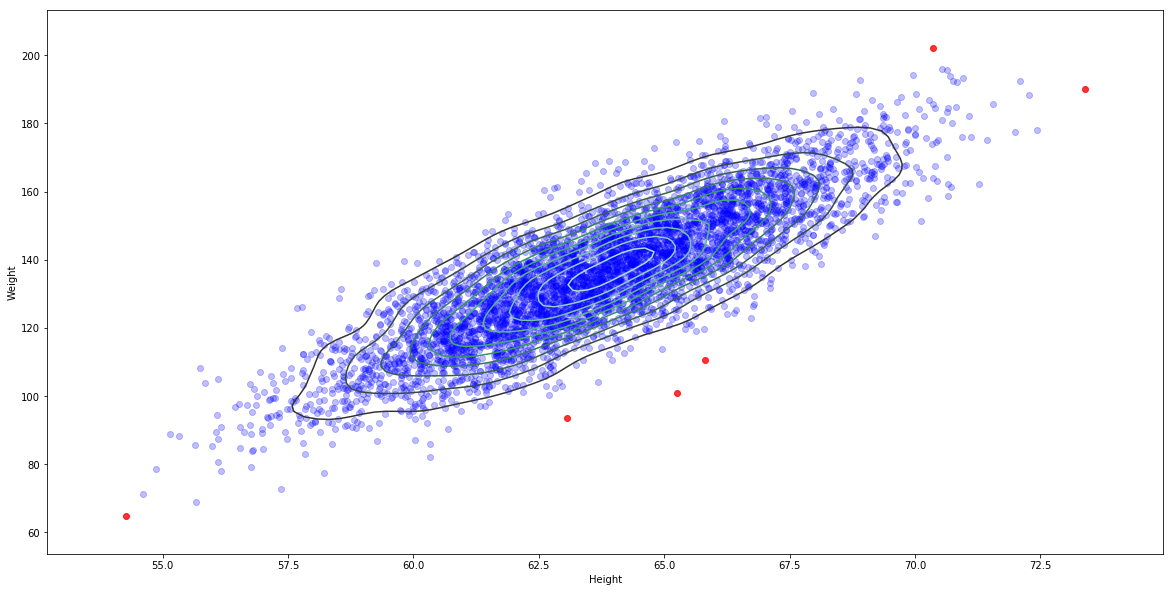

In [75]:
df_in =  df_hw[df_hw.Gender == 'Female'].iloc[:,1:3]
df_in2 = df_in.apply(zscore,0)
df_in2 = df_in2.iloc[:,0:2]

mu,sig = estimateGaussian(df_in)
#sig =  =np.array( [[1,0],[0,1]])
p = multivariateGaussian(df_in, mu,sig)

mask = (p < 1/100000)

plt.figure(figsize=(20,10))
sns.kdeplot(df_in.Height, df_in.Weight)
sns.regplot(x="Height", y="Weight", data=df_in[~mask],fit_reg=False,color='b',scatter_kws={'alpha':0.25})
sns.regplot(x="Height", y="Weight", data=df_in[mask],fit_reg=False,color='red')

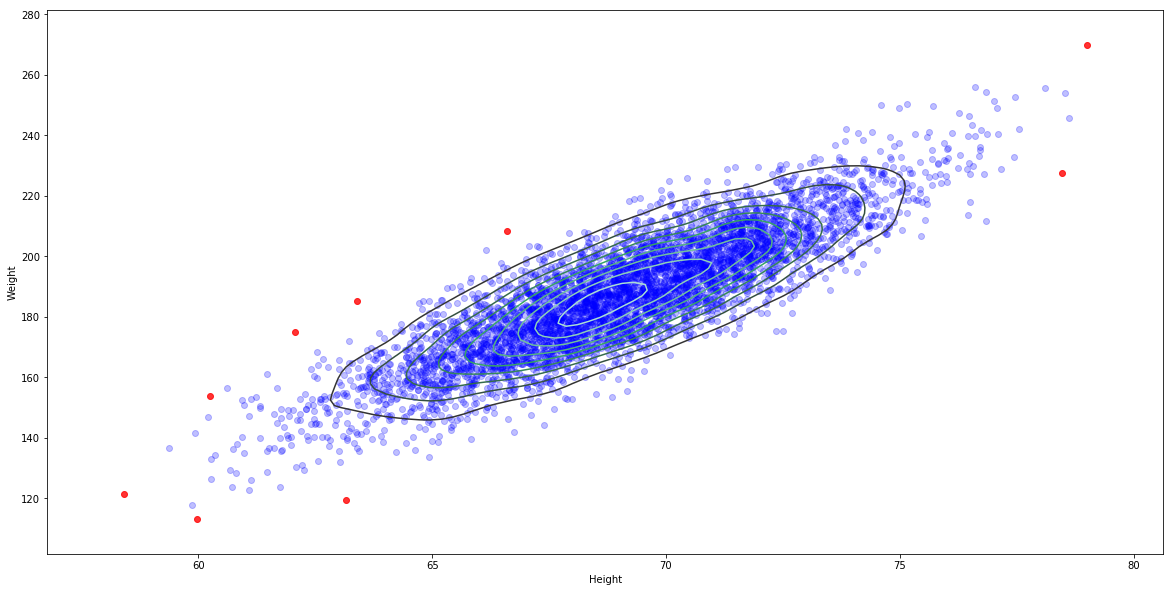

In [76]:
df_in =  df_hw[df_hw.Gender == 'Male'].iloc[:,1:3]
df_in2 = df_in.apply(zscore,0)
df_in2 = df_in2.iloc[:,0:2]

mu,sig = estimateGaussian(df_in)
#sig =  =np.array( [[1,0],[0,1]])
p = multivariateGaussian(df_in, mu,sig)

mask = (p < 1/100000)

plt.figure(figsize=(20,10))
sns.kdeplot(df_in.Height, df_in.Weight)
sns.regplot(x="Height", y="Weight", data=df_in[~mask],fit_reg=False,color='b',scatter_kws={'alpha':0.25})
sns.regplot(x="Height", y="Weight", data=df_in[mask],fit_reg=False,color='red')